In [ ]:
'''
Dataset Description
https://www.kaggle.com/sobhanmoosavi/us-accidents
This is a countrywide car accident dataset, which covers 49 states of the USA. The accident data are collected from February 2016 to 2021, 
using multiple APIs that provide streaming traffic incident (or event) data. These APIs broadcast traffic data captured by a variety of entities, 
such as the US and state departments of transportation, law enforcement agencies, traffic cameras, and traffic sensors within the road-networks.
Currently, there are about 1.5 million accident records in this dataset. 
Check here to learn more about this dataset.

Objective of this project
- Predict the severity of the accident from dataset's features 
(The severity of the accident, a number between 1 and 4, where 1 indicates the least impact on traffic)

Method
- Decision tree
- Random Forest
- XGBoost

#Github
https://github.com/SammySeries7/Stat5000prj
'''




In [2]:
from pyarrow.feather import (read_feather as read_dataframe,  # noqa
                             write_feather as write_dataframe,
                             FeatherError)

from feather.version import version as __version__
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
import plotly.graph_objs as go
import seaborn as sns
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
import pickle
import itertools
from PIL import Image

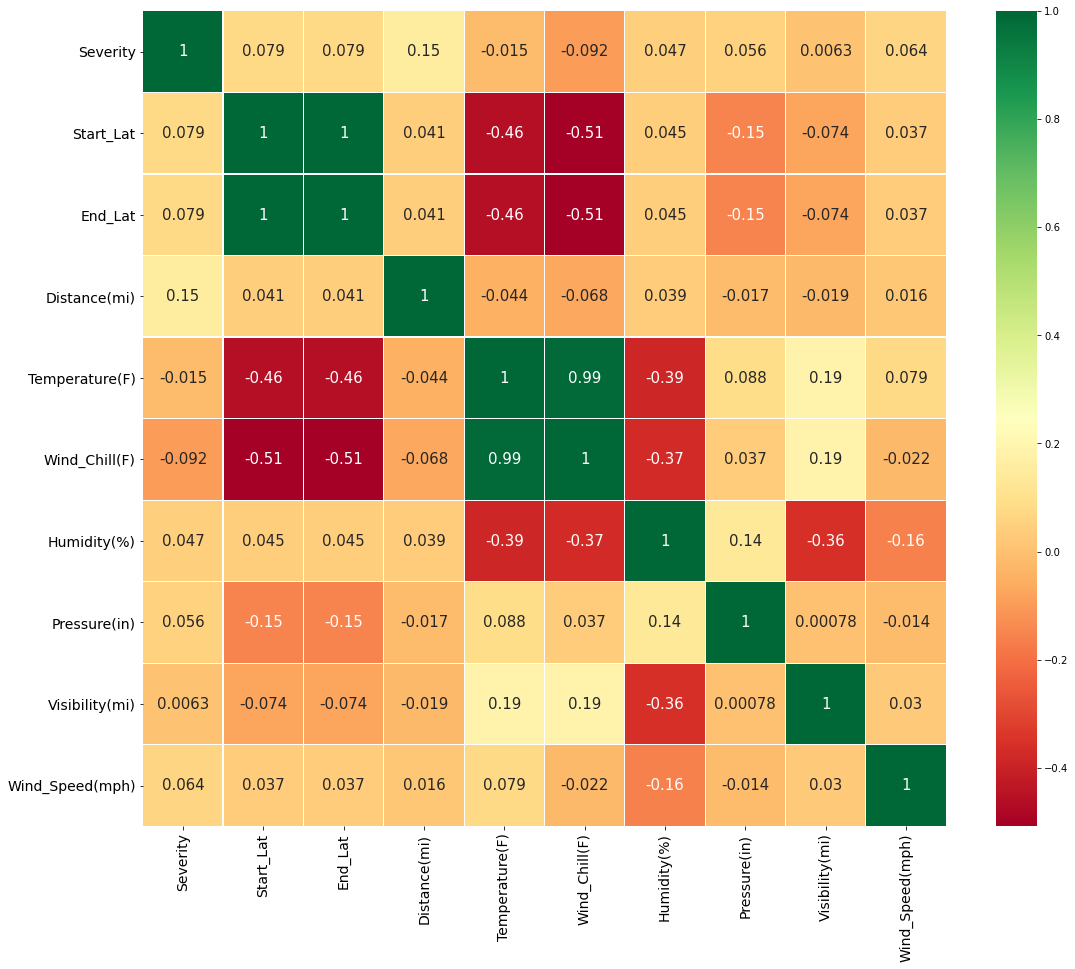

In [4]:
pop=pd.read_csv('State_Populations.csv')


#Import Data and Data adjustment
path = 'my_data.feather'
data = read_dataframe(path)
data['Severity']=data['Severity'].astype(int)

#According to heatmap, we can remove Wind_chill(F)
fig=sns.heatmap(data[['Severity','Start_Lat','End_Lat','Distance(mi)','Temperature(F)','Wind_Chill(F)','Humidity(%)','Pressure(in)','Visibility(mi)','Wind_Speed(mph)']].corr(),annot=True,cmap='RdYlGn',linewidths=0.2,annot_kws={'size':15})
fig=plt.gcf()
fig.set_size_inches(18,15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

#Removing features where number of null values>20% of entire values
data = data[data.columns[data.isnull().mean() < 0.2]]

C:\Users\TittiwatT\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\TittiwatT\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


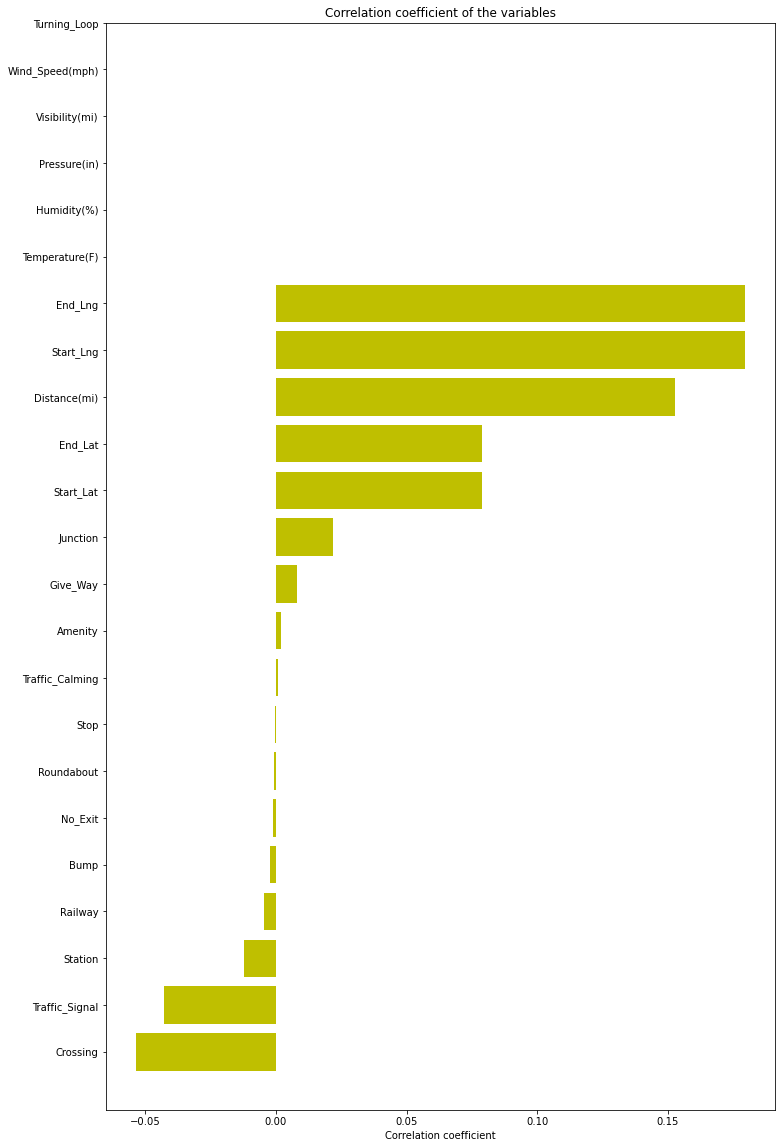

In [5]:
#Correlation with severity
x_cols = [col for col in data.columns if col not in ['Severity'] if data[col].dtype=='float64'or data[col].dtype=='bool']

labels = []
values = []
for col in x_cols:
    labels.append(col)
    values.append(np.corrcoef(data[col].values, data.Severity.values)[0,1])
corr_df = pd.DataFrame({'col_labels':labels, 'corr_values':values})
corr_df = corr_df.sort_values(by='corr_values')

ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(12,20))
rects = ax.barh(ind, np.array(corr_df.corr_values.values), color='y')
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.col_labels.values, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient of the variables")
plt.show()

In [6]:
#Copy dataframe
df=data.copy()

#Converting time data into separate columns
data['acc_year'] = pd.to_datetime(data['Start_Time']).dt.year
data['acc_month'] = pd.to_datetime(data['Start_Time']).dt.month
data['acc_hr_day'] = pd.to_datetime(data['Start_Time']).dt.hour
data['new_date'] = pd.to_datetime(data['Start_Time']).dt.date



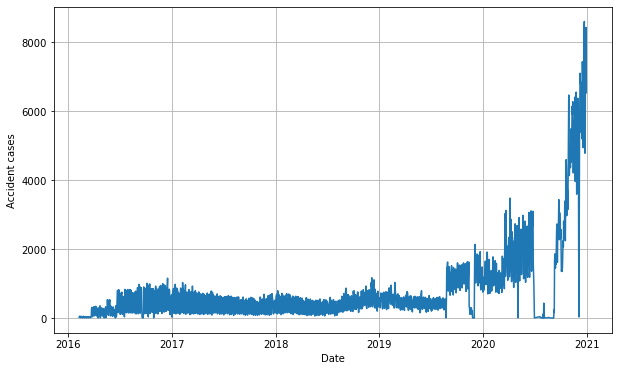

In [7]:
#Accident by date
temp = data.groupby('new_date')['ID'].count().reset_index()
plt.figure(figsize=(10,6))
ax=sns.lineplot(data=temp, x='new_date', y='ID')
ax.set(xlabel='Date', ylabel='Accident cases')
plt.grid()
plt.show()

C:\Users\TittiwatT\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


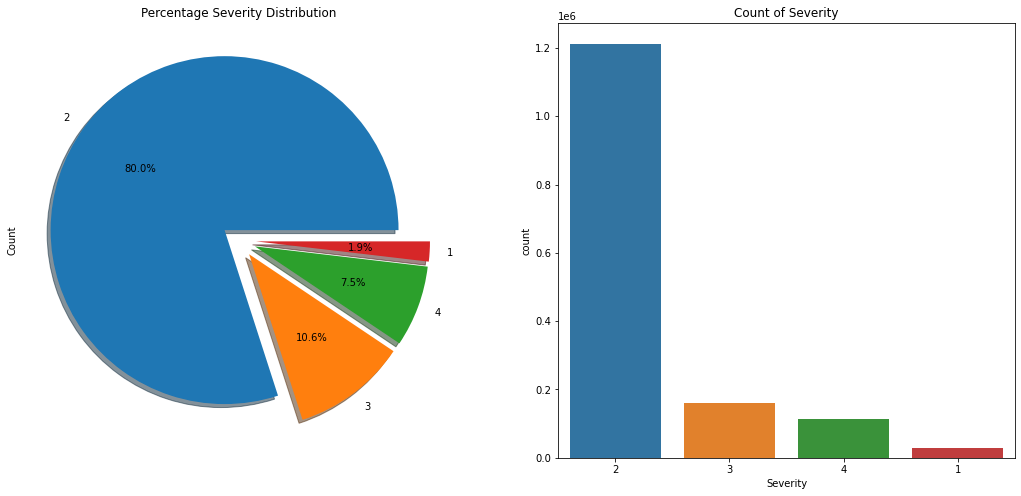

In [8]:
#Check distribution of severity

f,ax=plt.subplots(1,2,figsize=(18,8))
data['Severity'].value_counts().plot.pie(explode=[0.1,0.1,0.1,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Percentage Severity Distribution')
ax[0].set_ylabel('Count')
sns.countplot('Severity',data=data,ax=ax[1],order=data['Severity'].value_counts().index)
ax[1].set_title('Count of Severity')
plt.show()

Text(0, 0.5, '')

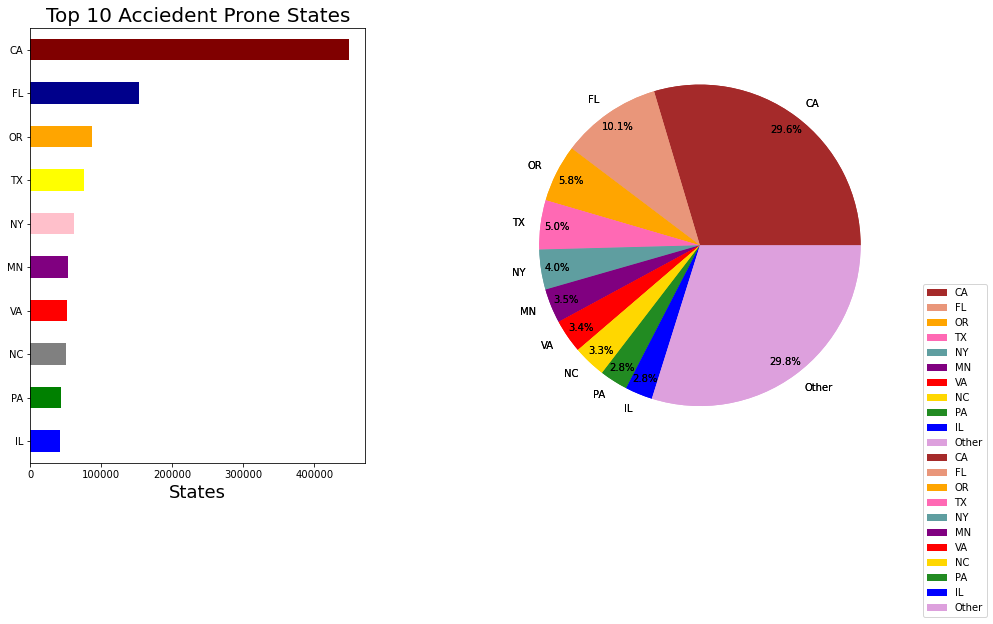

In [9]:
#Check top 10 accident prone state

fig,ax=plt.subplots(1,2,figsize=(15,8))
clr = ("blue", "green", "grey", "red", "purple",'pink','yellow','orange','darkblue','maroon')
data.State.value_counts().sort_values(ascending=False)[:10].sort_values().plot(kind='barh',color=clr,ax=ax[0])
ax[0].set_title("Top 10 Acciedent Prone States",size=20)
ax[0].set_xlabel('States',size=18)


count=data['State'].value_counts()
groups=list(data['State'].value_counts().index)[:10]
counts=list(count[:10])
counts.append(count.agg(sum)-count[:10].agg('sum'))
groups.append('Other')
type_dict=pd.DataFrame({"group":groups,"counts":counts})
clr1=('brown','darksalmon','orange','hotpink','cadetblue','purple','red','gold','forestgreen','blue','plum')
qx = type_dict.plot(kind='pie', y='counts', labels=groups,colors=clr1,autopct='%1.1f%%', pctdistance=0.9, radius=1.2,ax=ax[1])
plt.legend(loc=0, bbox_to_anchor=(1.15,0.4)) 
plt.subplots_adjust(wspace =0.5, hspace =0)
plt.ioff()
plt.ylabel('')
count=data['State'].value_counts()
groups=list(data['State'].value_counts().index)[:10]
counts=list(count[:10])
counts.append(count.agg(sum)-count[:10].agg('sum'))
groups.append('Other')
type_dict=pd.DataFrame({"group":groups,"counts":counts})
clr1=('brown','darksalmon','orange','hotpink','cadetblue','purple','red','gold','forestgreen','blue','plum')
qx = type_dict.plot(kind='pie', y='counts', labels=groups,colors=clr1,autopct='%1.1f%%', pctdistance=0.9, radius=1.2,ax=ax[1])
plt.legend(loc=0, bbox_to_anchor=(1.15,0.4)) 
plt.subplots_adjust(wspace =0.5, hspace =0)
plt.ioff()
plt.ylabel('')

  weather_condition          cases
0              rain  498186.977136
1          overcast  498910.606815
2            cloudy  497025.000000
3              snow  504012.372069
4  scattered clouds  500911.482318
5             clear  497734.994472
6              haze  505666.180306
7              fair  497046.490256
8      thunderstorm  522886.916798
9        wintry mix  724570.366743


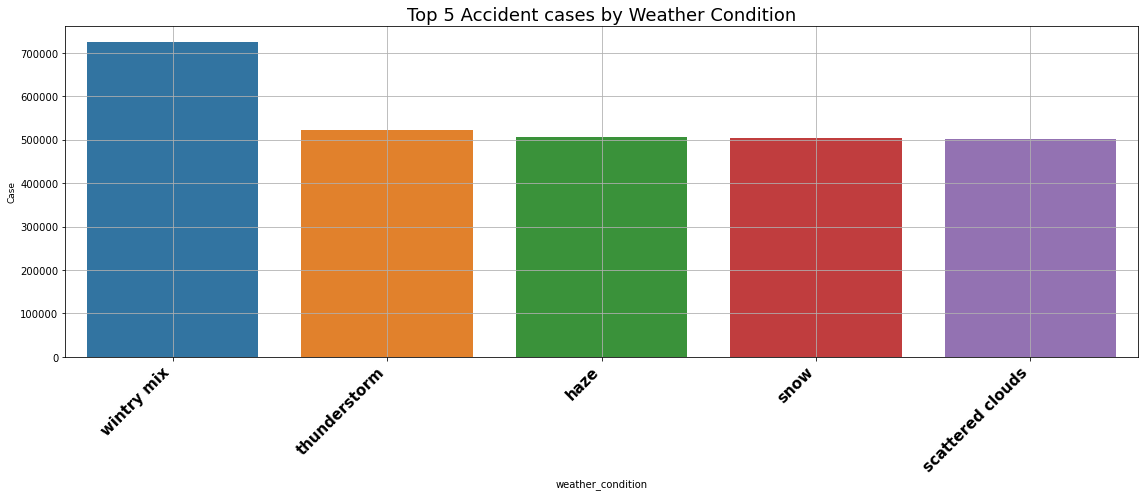

In [10]:
# 5 top weather condition for accident cases (Using Proportion) 
'''
The percent of data
rain 8.461977858454524
overcast 5.794808134748928
cloudy 32.783906220317874
snow 1.812852227874285
scattered clouds 3.1041565527576673
clear 11.887558836566265
haze 1.486216940709627
fair 31.125532959030757
thunderstorm 0.5291992950165693
n/a precipitation 0.026581991261582626
wintry mix 0.08449511366274774
'''

weather_con=data[data['Weather_Condition'].notna()]['Weather_Condition'].unique()


index = [False, False, False, False, False, False, False,
 False, False, True, False]
weather_con = np.delete(weather_con, index)

weather_con_prop=[]


data_row=data.count()[0]

for i in weather_con:
    
    prop=data[data['Weather_Condition']==i].count()['ID']/data_row
    weather_con_prop.append(data[data['Weather_Condition']==i].count()['ID']/(prop-0.00026581991261582626)*(.32783906220317874-0.00026581991261582626))

weather_con_prop_df=pd.DataFrame(list(zip(weather_con,weather_con_prop)), columns=['weather_condition','cases'])


print(weather_con_prop_df)
weather_con_prop_df=weather_con_prop_df[~weather_con_prop_df.isin([np.nan, np.inf, -np.inf]).any(1)]

a=weather_con_prop_df.sort_values('cases',ascending = False).head(5)
plt.figure(figsize=(16,7))
# make barplot and sort bars
hm=sns.barplot(x='weather_condition',
            y="cases", 
            data=a, 
            order=a.sort_values('cases',ascending = False).weather_condition)
plt.ylabel("Case", size=9)
plt.title("Top 5 Accident cases by Weather Condition", size=18)
plt.xticks(rotation=45, fontweight='bold', fontsize='15', horizontalalignment='right')
plt.grid()
plt.tight_layout()






    
     
    

    


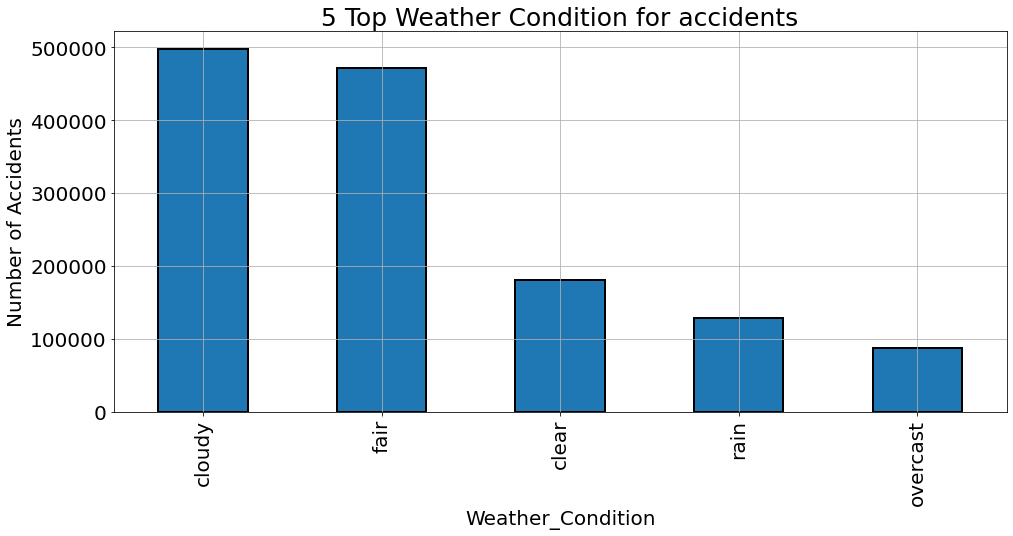

In [11]:
# 5 top weather condition for accidents (Real data)
fig, ax=plt.subplots(figsize=(16,7))
data['Weather_Condition'].value_counts().sort_values(ascending=False).head(5).plot.bar(width=0.5,edgecolor='k',align='center',linewidth=2)
plt.xlabel('Weather_Condition',fontsize=20)
plt.ylabel('Number of Accidents',fontsize=20)
ax.tick_params(labelsize=20)
plt.title('5 Top Weather Condition for accidents',fontsize=25)
plt.grid()
plt.ioff()


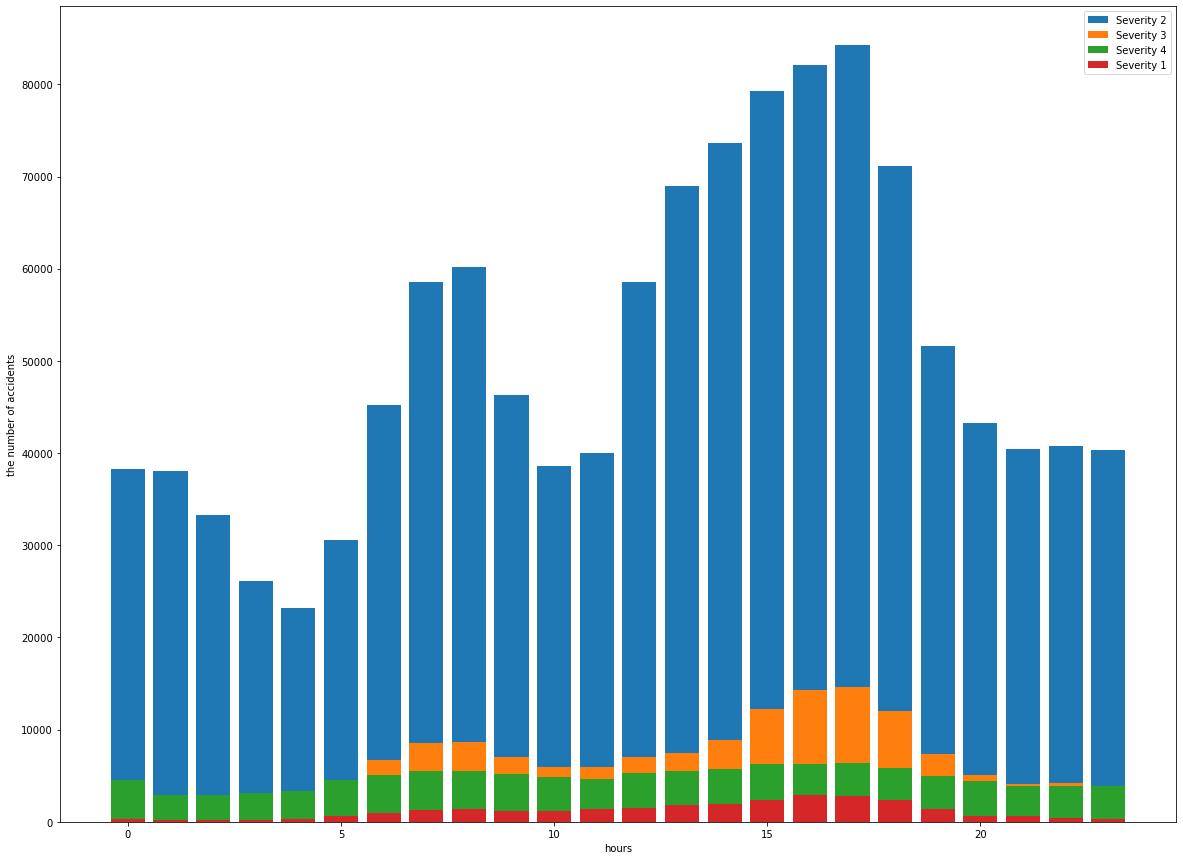

In [12]:
#Explore severity
#Severity vs hour
# It is bimodal. The first most accident time is 5.00-9.00. The second most accident time is 15.00-18.00.  
hours = list(set(pd.to_datetime(data['Start_Time']).dt.hour))
severity_1_hours = []
severity_2_hours = []
severity_3_hours = []
severity_4_hours = []
for i in hours:
    severity_1_hours.append(data[(data['Severity']==1)&(data['acc_hr_day']==i)].count()['ID'])
    severity_2_hours.append(data[(data['Severity']==2)&(data['acc_hr_day']==i)].count()['ID'])
    severity_3_hours.append(data[(data['Severity']==3)&(data['acc_hr_day']==i)].count()['ID'])
    severity_4_hours.append(data[(data['Severity']==4)&(data['acc_hr_day']==i)].count()['ID'])
    
plt.figure(figsize=(20,15))

plt.bar(hours, severity_2_hours, label='Severity 2')
plt.bar(hours, severity_3_hours, label='Severity 3')
plt.bar(hours, severity_4_hours, label='Severity 4')
plt.bar(hours, severity_1_hours, label='Severity 1')
plt.xlabel('hours')
plt.ylabel('the number of accidents')
plt.legend()


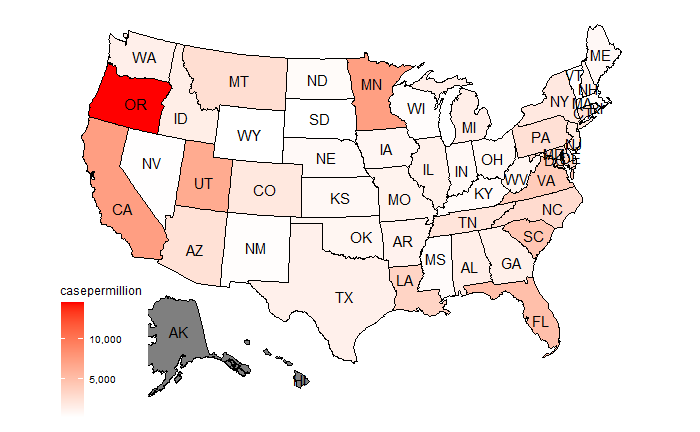

In [13]:
#Accident cases per million population by states
#Oregon has the highest accident cases per population.
# The data was plotted from R
im = Image.open('casepermill_usmap.png')
im

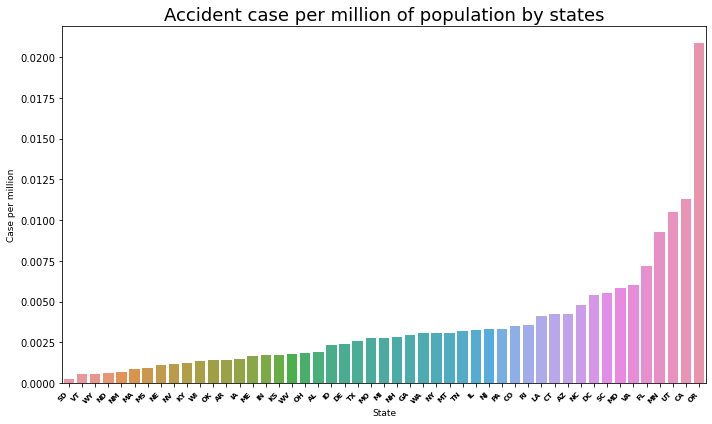

In [14]:
#Accident cases per popultaion by state
states = data.State.unique()
count_by_state=[]
casepermill=[]
ind=0
for i in data.State.unique():
    count_by_state.append(data[data['State']==i].count()['ID'])
    temppermill=count_by_state[ind]/pop[pop['Abbr']==i].sum()['2018 Population']
    casepermill.append(temppermill)
    ind=ind+1
df_casepermill=pd.DataFrame(list(zip(states,casepermill)), columns=['state','cases'])

plt.figure(figsize=(10,6))

# make barplot and sort bars
hm=sns.barplot(x='state',
            y="cases", 
            data=df_casepermill, 
            order=df_casepermill.sort_values('cases').state)
plt.xlabel("State", size=9)
plt.ylabel("Case per million", size=9)
plt.title("Accident case per million of population by states", size=18)
plt.xticks(rotation=45, fontweight='bold', fontsize='7', horizontalalignment='right')
plt.tight_layout()
plt.savefig("Accident case per million of population by states.png", dpi=100)

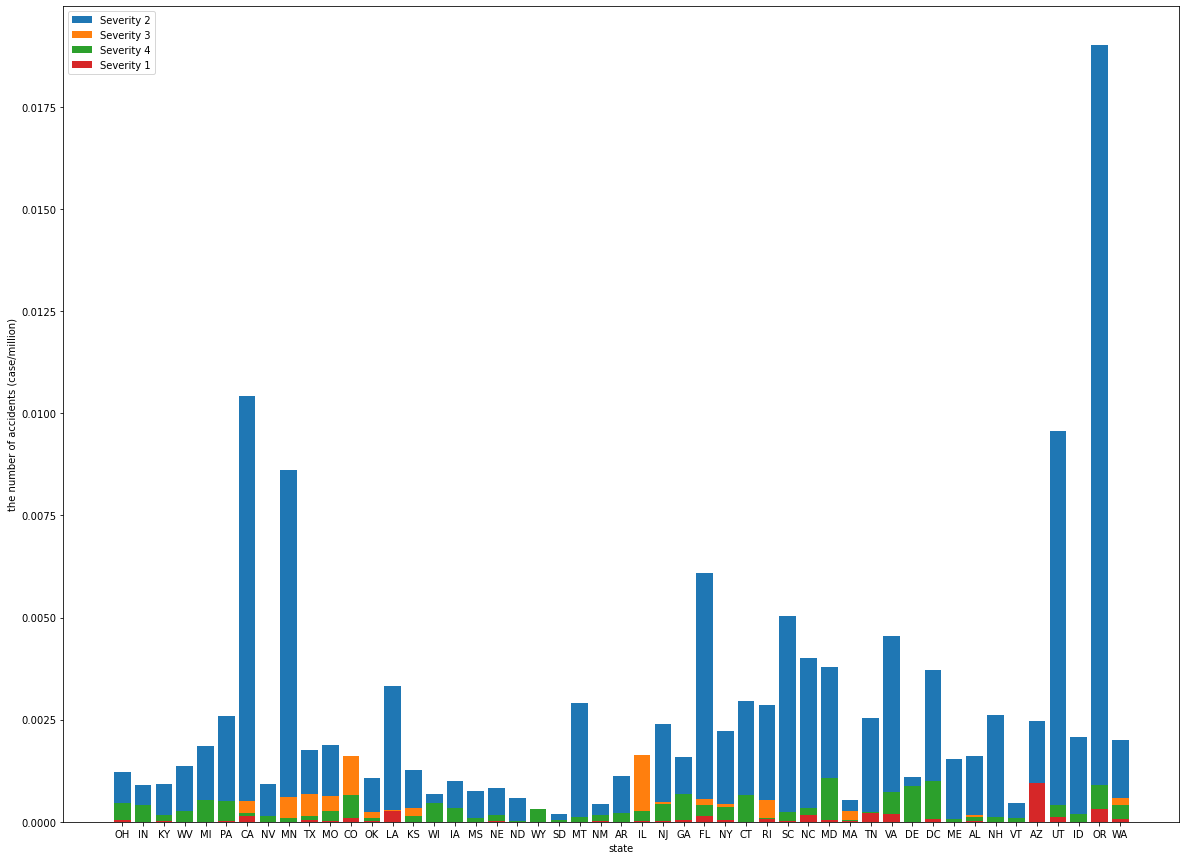

In [15]:
# Show accident cases based on severity and states

# Set labels
severity_1_state = []
severity_2_state = []
severity_3_state = []
severity_4_state = []
for i in states:
    severity_1_state.append(data[(data['Severity']==1)&(data['State']==i)].count()['ID']/pop[pop['Abbr']==i].sum()['2018 Population'])
    severity_2_state.append(data[(data['Severity']==2)&(data['State']==i)].count()['ID']/pop[pop['Abbr']==i].sum()['2018 Population'])
    severity_3_state.append(data[(data['Severity']==3)&(data['State']==i)].count()['ID']/pop[pop['Abbr']==i].sum()['2018 Population'])
    severity_4_state.append(data[(data['Severity']==4)&(data['State']==i)].count()['ID']/pop[pop['Abbr']==i].sum()['2018 Population'])


plt.figure(figsize=(20,15))

plt.bar(states, severity_2_state, label='Severity 2')
plt.bar(states, severity_3_state, label='Severity 3')
plt.bar(states, severity_4_state, label='Severity 4')
plt.bar(states, severity_1_state, label='Severity 1')
plt.xlabel('state')
plt.ylabel('the number of accidents (case/million)')

plt.legend()


In [16]:
#Count weather condition

Weather = data.Weather_Condition.value_counts()

#Fill na with np.nan
df = df.fillna(value=np.nan)

df['e_new_date'] = df['End_Time'].dt.strftime('%Y-%m-%d %H:%M:%S')

df['e_new_date'] = pd.to_datetime(df['e_new_date'])
df['reference']=datetime.strptime('2016-02-08 00:37:08','%Y-%m-%d %H:%M:%S')
df['Duration']=round((df['e_new_date']-df['reference'])/np.timedelta64(1,'m'))

for i in range(len(df)):
    if df.iloc[i,26]=='n/a precipitation':
        df.iloc[i,26]=np.nan 
print(data.dtypes)


ID                                    object
Severity                               int32
Start_Time               datetime64[ns, UTC]
End_Time                 datetime64[ns, UTC]
Start_Lat                            float64
Start_Lng                            float64
End_Lat                              float64
End_Lng                              float64
Distance(mi)                         float64
Description                           object
Street                                object
Side                                  object
City                                  object
County                                object
State                                 object
Zipcode                               object
Country                               object
Timezone                              object
Airport_Code                          object
Weather_Timestamp        datetime64[ns, UTC]
Temperature(F)                       float64
Humidity(%)                          float64
Pressure(i

In [14]:
#Using K-Nearest Neighbour to fill N/A weather_Condition
#Using KNN to fill N/A value by using latitude, Longtitude, and accident time.
df_notna=df[df['Weather_Condition'].notna()]
x=df_notna[['Start_Lat','Start_Lng','Duration']].values
y=df_notna[['Weather_Condition']].values
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)
scaler = StandardScaler()
scaler.fit(x_train)
x_train=scaler.transform(x_train)
x_test=scaler.transform(x_test)
classifier=KNeighborsClassifier(n_neighbors=5)
classifier.fit(x_train,y_train)
y_pred=classifier.predict(x_test)
print(classification_report(y_test,y_pred))
df_na=df[df['Weather_Condition'].isna()]
x_na=df_na[['Start_Lat','Start_Lng','Duration']].values
y_na_pred=classifier.predict(x_na)

#Input data into N/A
df['Weather_Condition'][df['Weather_Condition'].isna()]=y_na_pred

#Find mean value
df_notna=df[df['Humidity(%)'].notna()]['Humidity(%)'].values
med_humid=np.median(df_notna)
df_notna=df[df['Pressure(in)'].notna()]['Pressure(in)'].values
med_pressure=np.median(df_notna)
df_notna=df[df['Visibility(mi)'].notna()]['Visibility(mi)'].values
med_visiblity=np.median(df_notna)
df_notna=df[df['Wind_Speed(mph)'].notna()]['Wind_Speed(mph)'].values
med_windspeed=np.median(df_notna)
df_notna=df[df['Temperature(F)'].notna()]['Temperature(F)'].values
med_temp=np.median(df_notna)

#Make data tidier
df['Wind_Direction']=df['Wind_Direction'].replace(['Calm'], 'CALM')
df['Wind_Direction']=df['Wind_Direction'].replace(['North'], 'N')
df['Wind_Direction']=df['Wind_Direction'].replace(['South'], 'S')
df['Wind_Direction']=df['Wind_Direction'].replace(['East'], 'E')
df['Wind_Direction']=df['Wind_Direction'].replace(['Variable'], 'VAR')
df['Wind_Direction']=df['Wind_Direction'].replace(['West'], 'W')

C:\Users\TittiwatT\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


                  precision    recall  f1-score   support

           clear       0.58      0.75      0.65     36167
          cloudy       0.61      0.65      0.63     99761
            fair       0.76      0.78      0.77     93978
            haze       0.56      0.36      0.44      4506
        overcast       0.43      0.37      0.40     17611
            rain       0.52      0.36      0.42     25603
scattered clouds       0.32      0.15      0.20      9423
            snow       0.52      0.41      0.46      5389
    thunderstorm       0.38      0.12      0.19      1647
      wintry mix       0.35      0.15      0.21       246

        accuracy                           0.63    294331
       macro avg       0.50      0.41      0.44    294331
    weighted avg       0.62      0.63      0.62    294331



<ipython-input-14-e0e05df5d6a8>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Weather_Condition'][df['Weather_Condition'].isna()]=y_na_pred


In [15]:
#Fill N/A with mode for the following columns
df['Wind_Direction']=df['Wind_Direction'].fillna('CALM')
df['Amenity']=df['Amenity'].fillna(False)
df['Bump']=df['Bump'].fillna(False)
df['Crossing']=df['Crossing'].fillna(False)
df['Give_Way']=df['Give_Way'].fillna(False)
df['Junction']=df['Junction'].fillna(False)
df['Junction']=df['Junction'].fillna(False)
df['No_Exit']=df['No_Exit'].fillna(False)
df['Railway']=df['Railway'].fillna(False)
df['Roundabout']=df['Roundabout'].fillna(False)
df['Station']=df['Station'].fillna(False)
df['Stop']=df['Stop'].fillna(False)
df['Traffic_Signal']=df['Traffic_Signal'].fillna(False)
df['Turning_Loop']=df['Turning_Loop'].fillna(False)
df['Sunrise_Sunset']=df['Sunrise_Sunset'].fillna('Day')
df['Civil_Twilight']=df['Civil_Twilight'].fillna('Day')
df['Nautical_Twilight']=df['Nautical_Twilight'].fillna('Day')
df['Astronomical_Twilight']=df['Astronomical_Twilight'].fillna('Day')
df['Humidity(%)']=df['Humidity(%)'].fillna(med_humid)
df['Pressure(in)']=df['Pressure(in)'].fillna(med_pressure)
df['Visibility(mi)']=df['Visibility(mi)'].fillna(med_visiblity)
df['Wind_Speed(mph)']=df['Wind_Speed(mph)'].fillna(med_windspeed)
df['Temperature(F)']=df['Temperature(F)'].fillna(med_temp)

In [16]:
#The number data of each severity level
df['Severity'].value_counts(normalize=False)

2    1212382
3     161052
4     114452
1      28178
Name: Severity, dtype: int64

In [17]:
#Using one hot encoding
#A one hot encoding is a representation of categorical variables as binary vectors.

df_categories = df.select_dtypes(include=[object,bool])
df_cat_cols=df_categories.columns
for i in range(11):
    df_categories.drop(df_cat_cols[i], axis=1, inplace=True)
print(df_categories.columns)
df_cat_cols=df_categories.columns
X_label = df_categories.apply(LabelEncoder().fit_transform)
print(X_label.head())

# Create a OneHotEncoder object, and fit it to all of X
X_1hot = OneHotEncoder().fit_transform(X_label).toarray()


C:\Users\TittiwatT\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Index(['Wind_Direction', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing',
       'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station',
       'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop',
       'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')
   Wind_Direction  Weather_Condition  Amenity  Bump  Crossing  Give_Way  \
0              13                  5        0     0         0         0   
1               0                  5        0     0         0         0   
2               0                  4        0     0         0         0   
3               0                  4        0     0         0         0   
4               0                  4        0     0         0         0   

   Junction  No_Exit  Railway  Roundabout  Station  Stop  Traffic_Calming  \
0         0        0        0           0        0     0                0   
1         0        0        0           0        0   

In [169]:
#Column selection
df_1hot = pd.DataFrame(X_1hot)
data_onecode = pd.concat([df["Temperature(F)"],df["Humidity(%)"],df["Pressure(in)"],df["Visibility(mi)"], df["Wind_Speed(mph)"], df_1hot], axis=1, sort=False,)
data_onecode.columns = ["Temperature(F)", "Humidity(%)", "Pressure(in)", 
             "Visibility(mi)", "Wind_Speed(mph)", 'CALM 0', 'E 1', 'ENE 2', 'ESE 3', 'N 4', 'NE 5', 'NNE 6', 'NNW 7', 'NW 8', 'S 9',
 'SE 10', 'SSE 11', 'SSW 12', 'SW 13', 'VAR 14', 'W 15', 'WNW 16', 'WSW 17', 'clear 0', 'cloudy 1', 'fair 2', 'haze 3', 'overcast 4', 'rain 5',
 'scattered clouds 6', 'snow 7', 'thunderstorm 8', 'wintry mix 9', 'Amenity_F', 'Amenity_T', 'Bump_F','Bump_T', 'Crossing_F','Crossing_T',
       'Give_Way_F','Give_Way_T', 'Junction_F','Junction_T', 'No_Exit_F','No_Exit_T', 'Railway_F','Railway_T', 'Roundabout_F','Roundabout_T', 'Station_F','Station_T','Stop_F','Stop_T', 'Traffic_Calming_F','Traffic_Calming_T', 'Traffic_Signal_F','Traffic_Signal_T', 'Turning_Loop_F',
       'Sunrise_Sunset_D','Sunrise_Sunset_N', 'Civil_Twilight_D','Civil_Twilight_N', 'Nautical_Twilight_D','Nautical_Twilight_N','Astronomical_Twilight_D','Astronomical_Twilight_N']

In [170]:
#UnderSampling to reduce the number of level-2-severity cases

X=data_onecode.values
y=df['Severity'].values
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.3, random_state=42,stratify=y)
counter = Counter(y_train)
print(counter)
under = RandomUnderSampler(sampling_strategy={2.0:200000, 3.0:100000})
steps = [('u', under)]
pipeline = Pipeline(steps=steps)
X_train_re, y_train_re = pipeline.fit_resample(X_train, y_train)
counter = Counter(y_train_re)
print(counter)
dis_val_y_train=[1,2,3,4]
percentage = {i:np.sum(y_train_re == i)/y_train_re.shape[0]*100 for i in dis_val_y_train}

Counter({2: 848667, 3: 112736, 4: 80116, 1: 19725})
Counter({2: 200000, 3: 100000, 4: 80116, 1: 19725})


Train set accuracy = 0.7786833188220617
Test set accuracy = 0.7788048018996526

Importance of each feature:
 [0.03066234 0.01292339 0.1573364  0.00110515 0.13173035 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.09046387 0.26673286 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.09921303 0.         0.         0.
 0.01712427 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00068644 0.         0.         0.0174254  0.
 0.         0.         0.         0.13935565 0.         0.03524085]


'\n[Best]\nDT\nTrain set accuracy = 0.7897608843960484\nTest set accuracy = 0.7898663207422717\n'

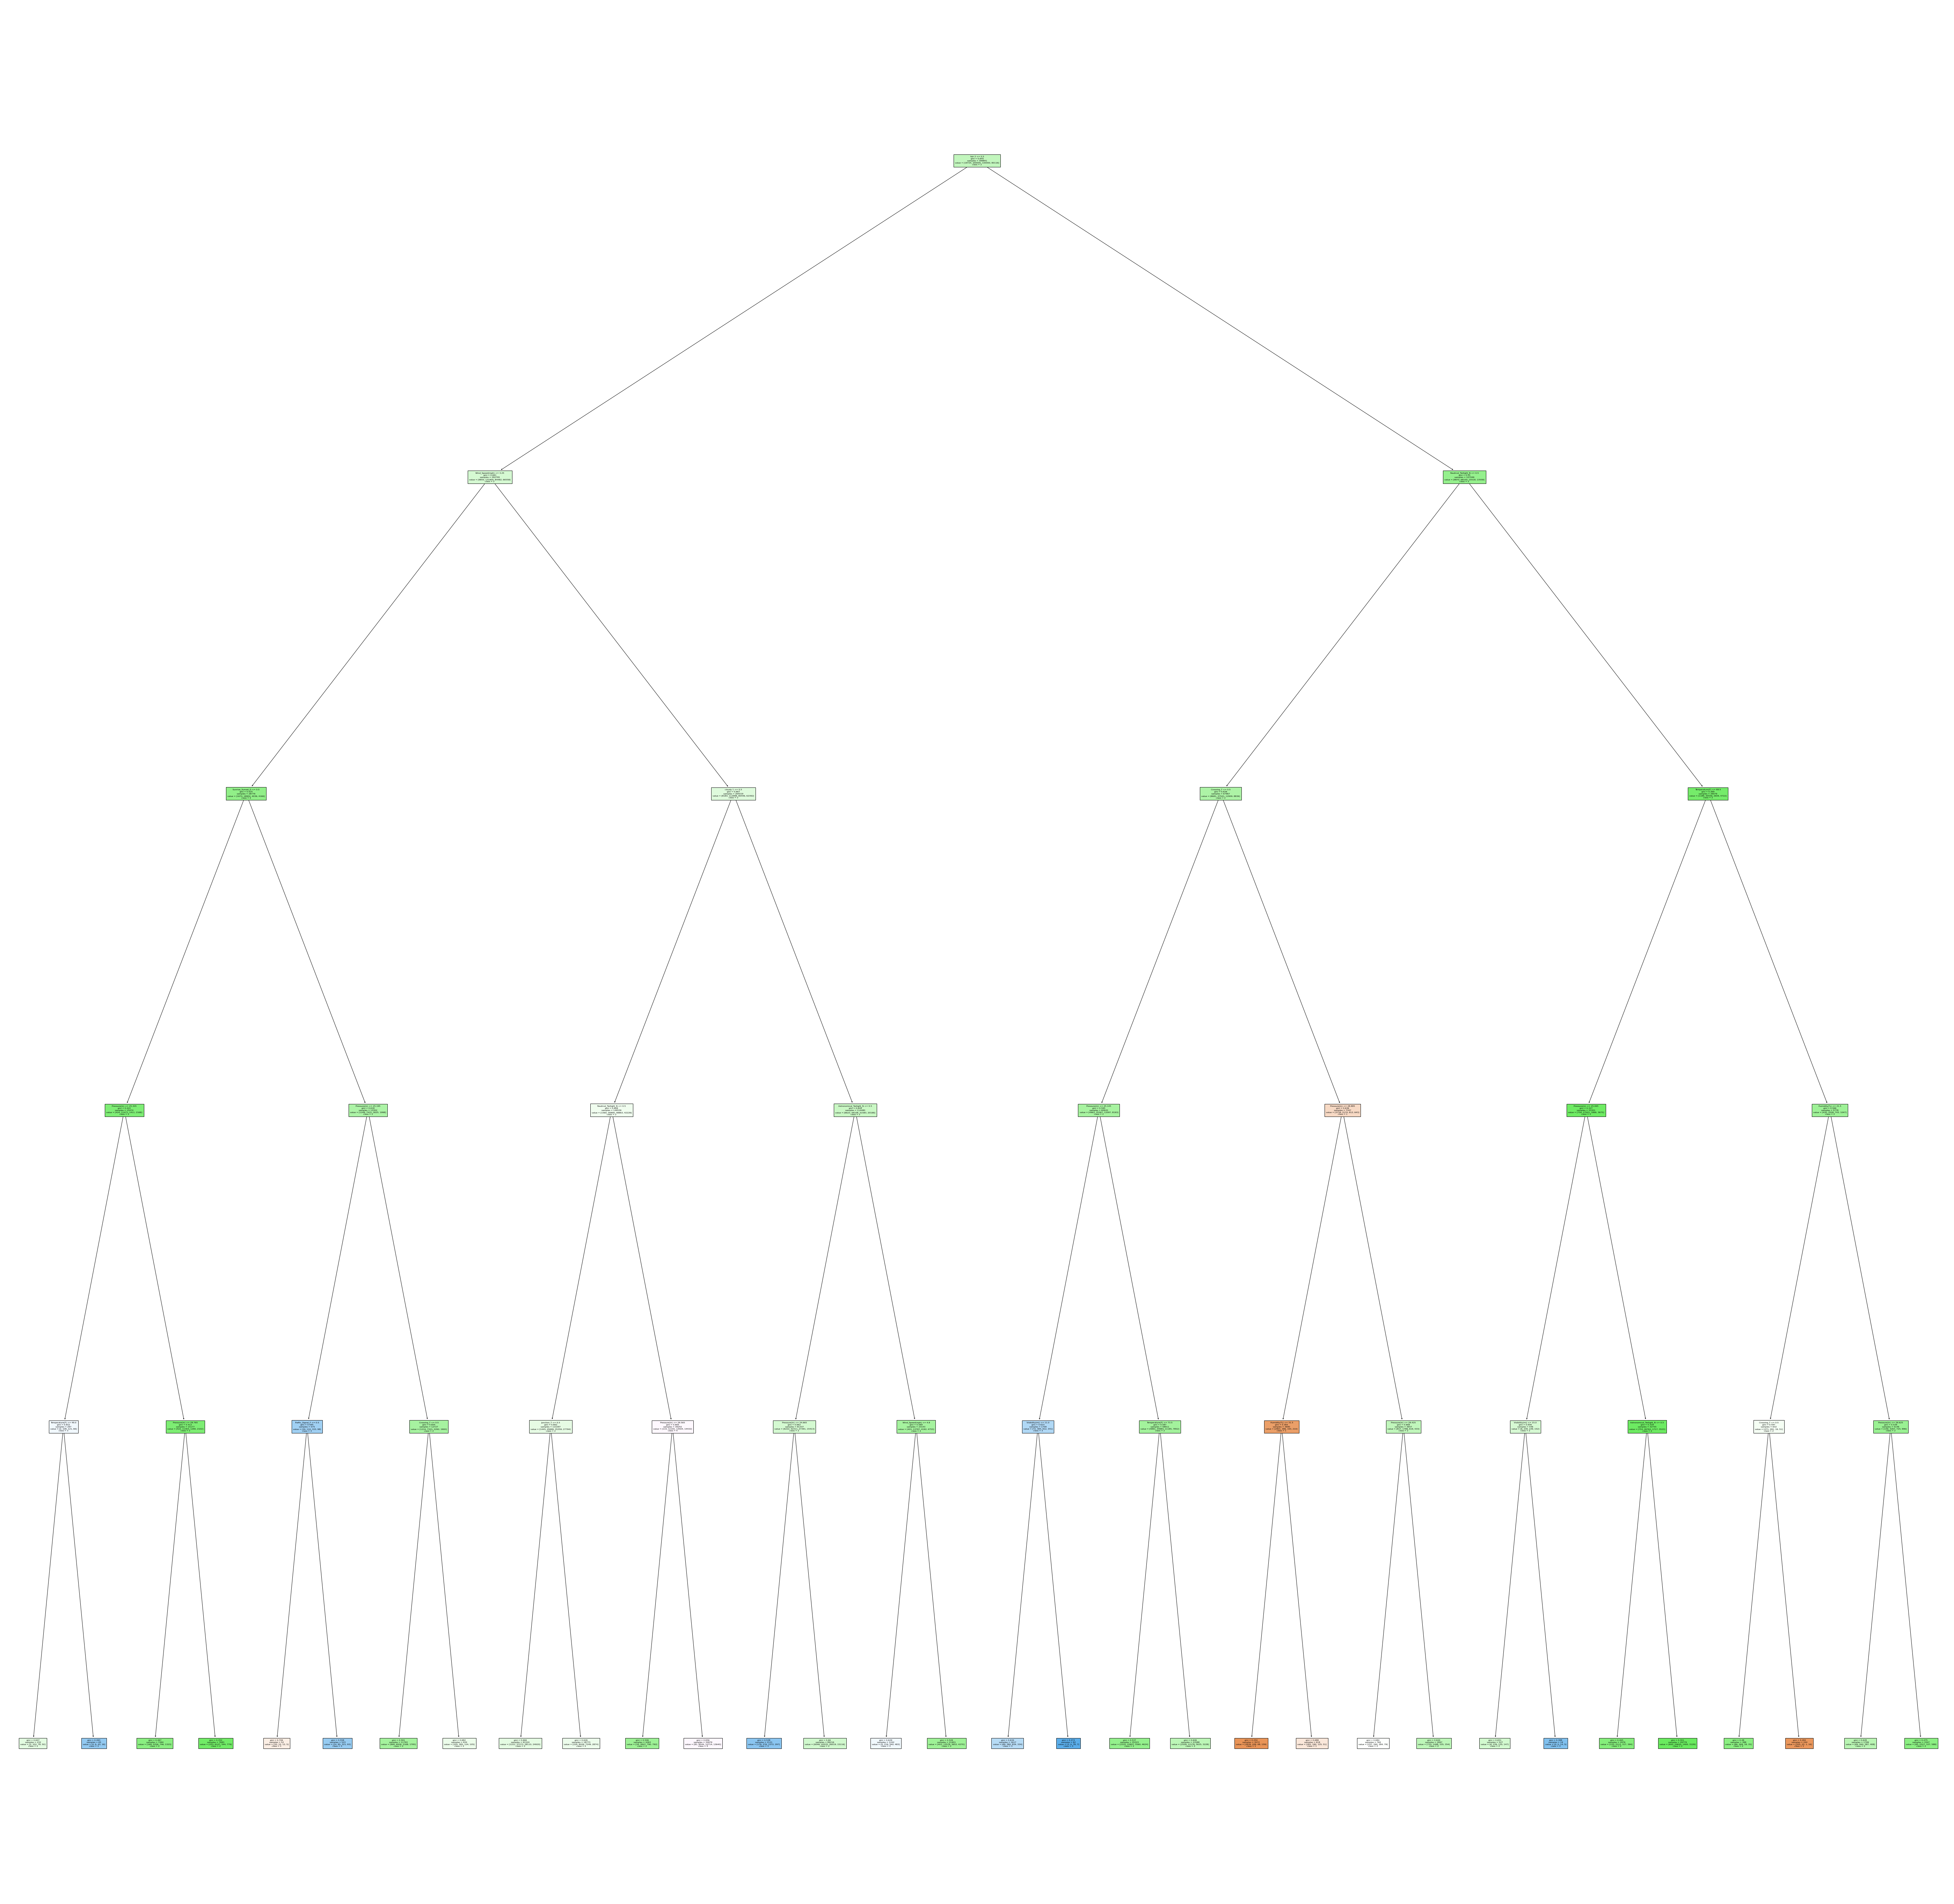

In [171]:
#Decsion tree
tree_clf = DecisionTreeClassifier(max_depth=5).fit(X_train_re, y_train_re)
print("Train set accuracy = " + str(tree_clf.score(X_train, y_train)))
print("Test set accuracy = " + str(tree_clf.score(X_test, y_test)))
# Export graph
fig = plt.figure(figsize=(100,100))
_ = tree.plot_tree(tree_clf, 
                   feature_names=data_onecode.columns,  
                   class_names=['1','2','3','4'],
                   filled=True, fontsize=6)
plt.savefig('tree_high_dpi', dpi=100)
print("\nImportance of each feature:\n", tree_clf.feature_importances_)

'''
[Best]
DT
Train set accuracy = 0.7897608843960484
Test set accuracy = 0.7898663207422717
'''


In [172]:
#Random Forest
rf = RandomForestClassifier(n_estimators=400,max_depth=5,min_samples_leaf=1,min_samples_split=2)
rf.fit(X_train_re, y_train_re)



print("\nModel Report")
print("Train Accuracy : %.4g" % metrics.accuracy_score(y_train, rf.predict(X_train)))
print("Test Accuracy : %.4g" % metrics.accuracy_score(y_test, rf.predict(X_test)))


'''
Model Report #n_est: (n_estimators=700,max_depth=30,min_samples_leaf=1,min_samples_split=2)
Train Accuracy : 0.8605
Test Accuracy : 0.7625

Model Report (n_estimators=700,max_depth=10,min_samples_leaf=1,min_samples_split=2)
Train Accuracy : 0.7941
Test Accuracy : 0.7928

Model Report (n_estimators=400,max_depth=10,min_samples_leaf=1,min_samples_split=2)
Train Accuracy : 0.7941
Test Accuracy : 0.7927

Model Report # (n_estimators=600,min_samples_leaf=1,min_samples_split=5)
Train Accuracy : 0.8691
Test Accuracy : 0.7478

Model Report # (n_estimators=400,min_samples_leaf=1,min_samples_split=5)
Train Accuracy : 0.8692
Test Accuracy : 0.7478

Model Report (n_estimators=200,min_samples_leaf=1,min_samples_split=5)
Train Accuracy : 0.8678
Test Accuracy : 0.7465

[Best]
RandomForestClassifier(n_estimators=400,max_depth=5,min_samples_leaf=1,min_samples_split=2)
Train Accuracy : 0.801
Test Accuracy : 0.8007

'''


Model Report
Train Accuracy : 0.8002
Test Accuracy : 0.8


'\nModel Report #n_est: (n_estimators=700,max_depth=30,min_samples_leaf=1,min_samples_split=2)\nTrain Accuracy : 0.8605\nTest Accuracy : 0.7625\n\nModel Report (n_estimators=700,max_depth=10,min_samples_leaf=1,min_samples_split=2)\nTrain Accuracy : 0.7941\nTest Accuracy : 0.7928\n\nModel Report (n_estimators=400,max_depth=10,min_samples_leaf=1,min_samples_split=2)\nTrain Accuracy : 0.7941\nTest Accuracy : 0.7927\n\nModel Report # (n_estimators=600,min_samples_leaf=1,min_samples_split=5)\nTrain Accuracy : 0.8691\nTest Accuracy : 0.7478\n\nModel Report # (n_estimators=400,min_samples_leaf=1,min_samples_split=5)\nTrain Accuracy : 0.8692\nTest Accuracy : 0.7478\n\nModel Report (n_estimators=200,min_samples_leaf=1,min_samples_split=5)\nTrain Accuracy : 0.8678\nTest Accuracy : 0.7465\n\n[Best]\nRandomForestClassifier(n_estimators=400,max_depth=5,min_samples_leaf=1,min_samples_split=2)\nTrain Accuracy : 0.801\nTest Accuracy : 0.8007\n\n'

In [173]:
#XGboost
'''
#RandomCV
x_cfl=XGBClassifier(num_class=4,n_jobs = 7)
prams={
'learning_rate':[0.1,0.15,0.2,0.3,0.5],
'n_estimators':[400],
'max_depth':[3,5,8,10],
'colsample_bytree':[0.5,0.8,1],
'subsample':[0.2,0.5,0.8,1],
}
random_cfl=RandomizedSearchCV(x_cfl,param_distributions=prams)
random_cfl.fit(X_train_re, y_train_re)
c=random_cfl.cv_results_
c=pd.DataFrame(c)
c.to_pickle('my_df.pickle')
d=pd.read_pickle('my_df.pickle')
d.to_csv('xg_randomcv_results.csv', index=False)
'''

x_cfl3=XGBClassifier(n_estimators=700, subsample=1.0, colsample_by_tree=1.0, max_depth=5,learning_rate=0.2,gamma=2)
x_cfl3.fit(X_train_re, y_train_re)
print("For XGboost:")
print("Train set accuracy = " + str(x_cfl3.score(X_train, y_train)))
print("Test set accuracy = " + str(x_cfl3.score(X_test, y_test)))

'''
[Best]
XGBClassifier(n_estimators=700, subsample=1.0, colsample_by_tree=1.0, max_depth=5,learning_rate=0.2,gamma=2)
Train set accuracy = 0.7497974075707378
Test set accuracy = 0.745651026779825

For XGboost:(n_estimators=700, subsample=1.0, colsample_by_tree=1.0, max_depth=5,learning_rate=0.2,gamma=1)
Train set accuracy = 0.7478459242172394
Test set accuracy = 0.74106239831142

XGBClassifier(n_estimators=700, subsample=1.0, colsample_by_tree=1.0, max_depth=5,learning_rate=0.2,gamma=3)
Train set accuracy = 0.7487976374895877
Test set accuracy = 0.744995822523196

For XGboost: (n_estimators=400, subsample=1.0, colsample_by_tree=1.0, max_depth=5,learning_rate=0.5,gamma=2)
Train set accuracy = 0.7451943191198254
Test set accuracy = 0.7385163361329757
'''

C:\Users\TittiwatT\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:23:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "colsample_by_tree" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:23:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
For XGboost:
Train set accuracy = 0.7487288502926754
Test set accuracy = 0.7434171760256805


'\n[Best]\nXGBClassifier(n_estimators=700, subsample=1.0, colsample_by_tree=1.0, max_depth=5,learning_rate=0.2,gamma=2)\nTrain set accuracy = 0.7497974075707378\nTest set accuracy = 0.745651026779825\n\nFor XGboost:(n_estimators=700, subsample=1.0, colsample_by_tree=1.0, max_depth=5,learning_rate=0.2,gamma=1)\nTrain set accuracy = 0.7478459242172394\nTest set accuracy = 0.74106239831142\n\nXGBClassifier(n_estimators=700, subsample=1.0, colsample_by_tree=1.0, max_depth=5,learning_rate=0.2,gamma=3)\nTrain set accuracy = 0.7487976374895877\nTest set accuracy = 0.744995822523196\n\nFor XGboost: (n_estimators=400, subsample=1.0, colsample_by_tree=1.0, max_depth=5,learning_rate=0.5,gamma=2)\nTrain set accuracy = 0.7451943191198254\nTest set accuracy = 0.7385163361329757\n'

In [32]:
#Test assumption that every level of severity has the same amount of data
X=data_onecode.values
y=df['Severity'].values
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.3, random_state=42,stratify=y)
counter = Counter(y_train)
print(counter)

under = RandomUnderSampler(sampling_strategy={2.0:19725,3.0:19725,4.0:19725})
steps = [('u', under)]
pipeline = Pipeline(steps=steps)
X_train_re, y_train_re = pipeline.fit_resample(X_train, y_train)
counter = Counter(y_train_re)
print(counter)
dis_val_y_train=[1,2,3,4]
percentage = {i:np.sum(y_train_re == i)/y_train_re.shape[0]*100 for i in dis_val_y_train}

Counter({2: 848667, 3: 112736, 4: 80116, 1: 19725})
Counter({1: 19725, 2: 19725, 3: 19725, 4: 19725})


In [33]:
#Decision Tree
tree_clf = DecisionTreeClassifier(max_depth=5).fit(X_train_re, y_train_re)
print("Train set accuracy = " + str(tree_clf.score(X_train, y_train)))
print("Test set accuracy = " + str(tree_clf.score(X_test, y_test)))

Train set accuracy = 0.3136856368563686
Test set accuracy = 0.31383184556527854


In [34]:
#Random Forest
rf = RandomForestClassifier(n_estimators=400,max_depth=5,min_samples_leaf=1,min_samples_split=2)
rf.fit(X_train_re, y_train_re)
print("\nModel Report")
print("Train Accuracy : %.4g" % metrics.accuracy_score(y_train, rf.predict(X_train)))
print("Test Accuracy : %.4g" % metrics.accuracy_score(y_test, rf.predict(X_test)))


Model Report
Train Accuracy : 0.3315
Test Accuracy : 0.331


In [35]:
x_cfl3=XGBClassifier(n_estimators=700, subsample=1.0, colsample_by_tree=1.0, max_depth=5,learning_rate=0.2,gamma=2)
x_cfl3.fit(X_train_re, y_train_re)
print("For XGboost:")
print("Train set accuracy = " + str(x_cfl3.score(X_train, y_train)))
print("Test set accuracy = " + str(x_cfl3.score(X_test, y_test)))


[11:56:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "colsample_by_tree" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:56:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\TittiwatT\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


For XGboost:
Train set accuracy = 0.42488532326213385
Test set accuracy = 0.42176245547689195


In [17]:
#Conclusion
0. The objective of this project is to predict the level of severity.
1. Windchill(F) is highly related with Temperature(F), so the attribute is deleted
2. The number of accident cases increases by time. It suddenly increases in 2021.
3. The severity in this dataset is imbalanced. The level 2 severity is around 80% of total.
4. California has the most accident cases while Orgeon has the most accident cases per population.
5. The worse weather condition tends to have more accident cases.
6. To solve the imbalance problem, undersampling was used to reduce the level 2 severity.
7. The input was run in three different models, which is decision tree, random forest, and XGBoost.
8  Decision tree has 77.8 % test accuracy
9. Random forest is the most suitable model for this dataset with 80% test accuracy.
10. XGBoost has 74.3 % test acccuracy
11. When undersampling level 2,3,and 4 to 19,275 (the number of level 1 severity data), all models have poorer performance.

#Reference
https://medium.com/@kohlishivam5522/understanding-a-classification-report-for-your-machine-learning-model-88815e2ce397
https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html
https://medium.com/@vaibhavgope02/predicting-accident-severity-with-us-accidents-dataset-4aeaaae0b0af
https://guopai.github.io/ml-blog05.html

SyntaxError: invalid syntax (<ipython-input-17-7215ffd46850>, line 2)

In [18]:
#Github
#https://github.com/SammySeries7/Stat5000prj

'apt-get' is not recognized as an internal or external command,
operable program or batch file.
